In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import glob
import tqdm
from typing import List, Tuple, Optional, Union
# from src.utils.blockwise_diag_matricies import BlockwiseDiagMatrix

In [3]:
class Wrapper(nn.Module):
    def __init__(self, n_experts:int,
                 d : int,
                 rank: int,
                 eps:float=1e-4):
        
        super(Wrapper, self).__init__()
        self.n_experts = n_experts
        self.d = d
        self.rank = rank
        
        self.A = nn.Parameter(torch.randn(n_experts, d, rank) / (rank ** 0.5))
        self.B = nn.Parameter(torch.zeros(n_experts, rank, d))
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError("Use matmul operator '@' instead of forward method.")
    
    def __matmul__(self, core: torch.Tensor) -> torch.Tensor:
        #wrapper @ core 
        #multiply core with B2, then permute, then multiply with B1
        #if the core is 2d padd it to 3d
        if core.dim() == 2:
            core = core.unsqueeze(0)  #shape of (1, d_out, d_in)
        out = self.B @ core  #shape of (n_experts, rank, d_in)
        out = self.A @ out +  core  #shape of (n_experts, d_out, d_in)
        return out
    
    def __rmatmul__(self, core: torch.Tensor) -> torch.Tensor:
        #core @ wrapper 
        #multiply core with A, then permute, then multiply with B
        #if the core is 2d padd it to 3d
        if core.dim() == 2:
            core = core.unsqueeze(0)  #shape of (1, d_out, d_in)
        out = core @ self.A  #shape of (n_experts, d_out, rank)
        out = out @ self.B + core  #shape of (n_experts, d_out, d_in)
        return out
    
    @property
    def params_per_expert(self) -> int:
        return self.d * self.rank * 2
        

In [4]:
d_1,d_2,d_3 = 128, 768, 64


a = torch.randn(d_1, d_2, d_3)

idxs = torch.stack([torch.randperm(d_3) for _ in range(d_1)], dim=0)
a_permuted = a[torch.arange(d_1).unsqueeze(-1), :, idxs]
print(a_permuted.shape)

torch.Size([128, 64, 768])


In [5]:
model = "Qwen/Qwen3-30B-A3B-Base"
layer = 0
proj = "down_proj"
device = torch.device("cuda:7")
weights_paths = glob.glob(f"../LLM_data/{model}/original_weights/layer_{layer}/mlp.expert_*.{proj}.pt")
print("Found n weights:", len(weights_paths))
weights = [torch.load(path, map_location=device)["weight"].to(torch.float32).detach() for path in weights_paths]

hessian_path = "hessian_diag/SlimPajama-627B/n_samples_512_ctx_len_8192/seed_0"
hessian_diags = [
    torch.load(w.replace("original_weights", hessian_path), map_location=device)["hessianDiag"].to(torch.float32) for w in weights_paths
]

Found n weights: 128


In [ ]:
class CompressedProj(nn.Module):
    def __init__(self, weights:list[torch.Tensor], hessian_diags:list[torch.Tensor],
                 d_low_rank:int=64,
                 device:torch.device=torch.device("cpu"),
                 eps:float=1e-4):
        super().__init__()
        self.original_weights = nn.Buffer(torch.stack(weights))  # (n_experts, out_dim, in_dim)
        self.hessian_diags = nn.Buffer(torch.stack(hessian_diags))  # (n_experts, in_dim)
        
        #calculate the loss scaling just to make sure that the losses are readable
        self.loss_scaling = torch.sum(self.original_weights**2 * self.hessian_diags.unsqueeze(1),
                                      dim=(0,1,2), keepdim=True)  #shape (n_experts, 1, 1)
        
        self.wrapper_A = Wrapper(n_experts=self.n_experts,
                                    d=self.d_out,
                                    rank=d_low_rank,
                                    eps=eps)
        self.wrapper_B = Wrapper(n_experts=self.n_experts,
                                    d=self.d_in,
                                    rank=d_low_rank,
                                    eps=eps)
        self.core_weight = nn.Parameter(torch.mean(self.original_weights, dim=0),requires_grad=True)  # (d_out, d_in)
    
    
    @ property
    def d_in(self) -> int:
        return self.original_weights.shape[2]
    @ property
    def d_out(self) -> int:
        return self.original_weights.shape[1]
    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wrapper_B(x) #shape of (..., n_experts, d_core)
        out = F.linear(out.view(-1, self.d_core), self.core_weight).view(*x.shape[:-2], 
                                                                         self.n_experts, self.d_core)
        
        out = self.wrapper_A(out)  #shape of (..., n_experts, d_out)
        return out
    
    @property
    def n_experts(self)->int:
        return self.original_weights.shape[0]
    
    def reconstruct_weight(self)->torch.Tensor:
        return self.wrapper_A @ (self.core_weight @ self.wrapper_B)  # (n_experts, out_dim, in_dim)
    
    def recon_loss(self)->torch.Tensor:
        W_recon = self.reconstruct_weight()
        # print("W_recon:", W_recon)
        # raise NotImplementedError("Debugging print statement added.")
        assert W_recon.shape == self.original_weights.shape, \
            f"Reconstructed weight shape {W_recon.shape} does not match original weight shape {self.original_weights.shape}"
        # print(self.original_weights)
        loss = (W_recon - self.original_weights)**2 * self.hessian_diags.unsqueeze(1) #shape (n_experts, out_dim, in_dim)
        #multiply by hessian diag
        # print("loss shape:", loss.shape)
        # print("loss scaling shape:", self.loss_scaling.shape)
        return torch.sum(loss/self.loss_scaling)/self.n_experts
    
    def get_new_params(self)->int:
        n_params = 0
        n_params += self.core_weight.numel()
        count_wrapper_params = lambda x: sum(p.numel() for p in x.parameters())
        
        n_params += count_wrapper_params(self.wrapper_A)
        n_params += count_wrapper_params(self.wrapper_B)
        return n_params
    
    def get_original_params(self)->int:
        return self.original_weights.numel()
    
    def get_sparsity_factor(self)->float:
        return self.get_new_params()/self.get_original_params()
    
    @property
    def params_per_expert(self) -> int:
        print("here")
        return self.core_weight.numel() + self.wrapper_A.params_per_expert + self.wrapper_B.params_per_expert
        
    @property
    def original_params_per_expert(self) -> int:
        return self.original_weights[0].numel()  
    
    def get_active_sparsity_factor(self) -> float:
        print("params per expert:", self.params_per_expert)
        print("original params per expert:", self.original_params_per_expert)
        return self.params_per_expert / self.original_params_per_expert
        

In [11]:
test_module = CompressedProj(weights, [torch.ones_like(h) for h in hessian_diags], device=device, eps=1e-1,
                             d_low_rank=64
                             ).to(device)
print("sparsity factor:", test_module.get_sparsity_factor())
print("active sparsity factor:", test_module.get_active_sparsity_factor())

optimizer = torch.optim.Adam(test_module.parameters(), lr=1e-3)

# optimizer = torch.optim.AdamW(test_module.parameters(), lr=1e-3,
#                               weight_decay=1e-1)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                                                    #    threshold=1e-2)

losses = []
bar = tqdm.tqdm(range(1000), desc="Training")
for step in bar:
    optimizer.zero_grad()
    loss = test_module.recon_loss()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    # scheduler.step(loss)
    bar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
    

sparsity factor: 0.23697916666666666
here
params per expert: 1933312
original params per expert: 1572864
here
active sparsity factor: 1.2291666666666667


Training: 100%|██████████| 1000/1000 [01:03<00:00, 15.71it/s, loss=0.595, lr=0.001]


In [12]:
recon_weight = test_module.reconstruct_weight().detach()
print(recon_weight)

tensor([[[ 1.4477e-02, -3.1076e-02,  2.4630e-02,  ...,  9.8412e-04,
          -3.4376e-03,  7.4653e-03],
         [-1.8913e-02, -2.2301e-02,  1.0429e-02,  ...,  9.5095e-04,
          -3.6786e-02,  2.3512e-02],
         [ 2.2679e-02, -7.3982e-03, -1.2650e-02,  ..., -4.1586e-04,
          -1.1480e-02,  1.0914e-02],
         ...,
         [-1.4462e-02,  3.4229e-02,  5.6580e-03,  ...,  6.5276e-03,
           4.8760e-03, -6.9675e-03],
         [ 5.6646e-03, -4.8215e-03,  9.0884e-03,  ..., -4.8578e-03,
          -1.2205e-02, -1.8321e-02],
         [-1.0626e-02,  7.1883e-04, -1.6850e-04,  ..., -1.4577e-02,
           1.2807e-02,  8.0756e-03]],

        [[-5.2546e-03,  1.8567e-02,  2.5397e-03,  ...,  2.3321e-03,
           8.2955e-03,  2.2693e-02],
         [ 1.7396e-03, -1.8426e-02, -8.1471e-04,  ...,  1.3137e-02,
          -1.3957e-03,  3.0966e-02],
         [ 9.3203e-04,  2.2127e-04, -1.4360e-03,  ...,  2.1665e-02,
          -5.2939e-03, -1.6228e-02],
         ...,
         [-7.3940e-04, -5

In [13]:
test_module.original_weights

tensor([[[ 3.4180e-02, -3.7842e-02, -1.1902e-03,  ..., -1.9531e-03,
          -3.0884e-02,  1.6846e-02],
         [ 1.7822e-02, -4.1016e-02,  1.3672e-02,  ...,  1.2695e-02,
          -5.6641e-02,  1.8188e-02],
         [ 2.2827e-02, -2.5146e-02, -1.2207e-02,  ..., -2.9175e-02,
          -3.2715e-02,  1.9409e-02],
         ...,
         [ 1.2390e-02,  3.7109e-02,  1.6968e-02,  ..., -3.8330e-02,
           2.3682e-02,  1.1902e-02],
         [ 1.2390e-02, -6.4697e-03,  2.1118e-02,  ..., -2.8320e-02,
          -3.3447e-02, -1.0132e-02],
         [-2.0508e-02,  1.4801e-03,  1.4893e-02,  ..., -4.5898e-02,
           1.8188e-02,  1.2207e-02]],

        [[-1.8799e-02,  3.1250e-02, -1.2398e-04,  ..., -2.5879e-02,
           1.4954e-02, -2.8381e-03],
         [ 1.4648e-02, -1.0010e-02,  2.5558e-04,  ...,  2.5879e-02,
          -4.6997e-03,  1.5869e-02],
         [-2.1484e-02,  3.5248e-03,  1.0986e-03,  ...,  9.0332e-03,
          -5.4932e-03, -7.8735e-03],
         ...,
         [ 8.6060e-03, -1

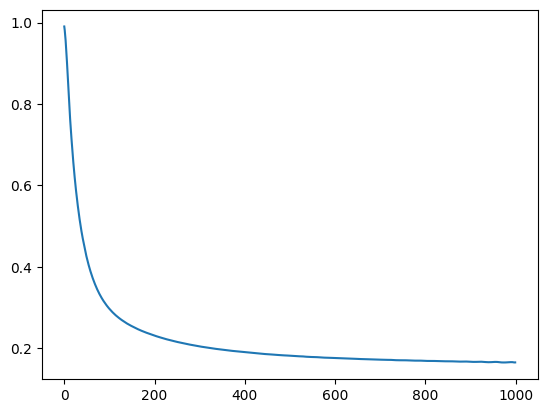

In [22]:
import matplotlib.pyplot as plt
plt.plot(losses)
# plt.yscale("log")
# plt.xscale("log")